In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
import linecache
import torch

In [58]:
# Data Preprocessing

# CURRENT_PATH = os.getcwd()

# def read_and_save(feature_path, files, label_path):

#     for file in files:
#         # Label

#         filename = file.split('/')[-1] + '.pkl'
        
#         # Data

#         data = pd.read_csv(file,
#                     sep = ' ', skiprows= 5 , header = None, comment='#')
#         data.columns = pd.Index(['Index', 'Sensor', 'Position', 'Value'])
#         data = data.drop(columns= ['Index'])
#         pd.to_pickle(data, os.path.join(os.getcwd(), feature_path, filename))

#         alcoholic = 1 if 'a' in filename else 0
#         stimulus = ''.join(linecache.getline(file, 4).split()[1:3])
#         with open(os.path.join(os.getcwd(), label_path), 'a') as file:
#             file.write(stimulus + ' ' + str(alcoholic) + ' ' + filename+ '\n')

        
        
# def process_directory(path, feature_path, label_path):
#     print(f"Processing directory: {path}")

#     subdirs = [os.path.join(path, name) for name in os.listdir(path)]
#     if os.path.isfile(subdirs[0]):
#         read_and_save(feature_path, subdirs, label_path)
#     else:
#         for dir_ in subdirs:
#             process_directory(dir_, feature_path, label_path)


# process_directory(os.path.join(CURRENT_PATH, 'data/EEG/SMNI_CMI_TEST/'), 'data/eeg/test/', 'data/eeg/test_label.txt')
# process_directory(os.path.join(CURRENT_PATH, 'data/EEG/SMNI_CMI_TRAIN/'), 'data/eeg/train/', 'data/eeg/train_label.txt')

In [2]:
# %load './data_scripts/eeg_data.py'



class EegDataset(Dataset):
    def __init__(self,tgt_transform = None, transform = None, train = True, channel = 'S1obj'):
        self.channel = channel
        self.train = train
        self.label_path = 'data/eeg/train_label.txt' if train else 'data/eeg/test_label.txt'
        self.labels = pd.read_csv(self.label_path, sep=' ', header= None)
        self.labels = self.labels[self.labels[0] == self.channel]
        self.feature_dir = 'data/eeg/train/' if train else 'data/eeg/test/'
        self.transform = transform
        self.tgt_transform = tgt_transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        
        feature_path = os.path.join(self.feature_dir, self.labels.iloc[index, 2])
        label = self.labels.iloc[index, 1]
        feature_matrix = pd.read_pickle(feature_path)
        if self.transform:
            feature_matrix = self.transform(feature_matrix)
        if self.tgt_transform:
            label = self.tgt_transform(label)
        
        return feature_matrix, label
        
        
def transform(x):
    assert(x.shape == (256 * 64, 3))
    assert(list(x.columns) == ['Sensor', 'Position', 'Value'])
    value = x['Value']
    value = torch.from_numpy(value.to_numpy()).reshape(256, 64).to(torch.float32)
    return value   

In [3]:
# model and Nesterov optimizer
import math 
import torch
import torch.nn as nn

class TraceLayer(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.weight = nn.Parameter(torch.empty(self.input_shape))
        self.bias = nn.Parameter(torch.empty(1))
        self.reset_parameters()
        self.sigmoid = nn.Sigmoid()
    def reset_parameters(self) -> None:

        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
    def forward(self, x):
        x = torch.matmul(x, torch.transpose(self.weight, 1, 0))
        x = torch.diagonal(x, dim1=1, dim2= 2)
        x = x.sum(dim = 1) + self.bias
        x = self.sigmoid(x.reshape(-1, 1))
        return x
    
    
class FlattenTraceLayer(nn.Module):
    def __init__(self):
        super(FlattenTraceLayer, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid = nn.Sequential(
            nn.Linear(256 * 64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        sigmoid = self.linear_sigmoid(x)
        return sigmoid


class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(20)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(20)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(20)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(20, 40, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(40)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(40, 40, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(40)
        self.relu5 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d(40, 40, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(40)
        self.relu6 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv7 = nn.Conv2d(40, 60, kernel_size=3)
        self.bn7 = nn.BatchNorm2d(60)
        self.relu7 = nn.ReLU(inplace=True)
        self.conv8 = nn.Conv2d(60, 40, kernel_size=1)
        self.bn8 = nn.BatchNorm2d(40)
        self.relu8 = nn.ReLU(inplace=True)
        self.conv9 = nn.Conv2d(40, 20, kernel_size=1)
        self.bn9 = nn.BatchNorm2d(20)
        self.relu9 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(kernel_size=5)
        self.fc = nn.Linear(480, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose = False):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.relu6(self.bn6(self.conv6(x)))
        x = self.pool2(x)
        x = self.relu7(self.bn7(self.conv7(x)))
        x = self.relu8(self.bn8(self.conv8(x)))
        x = self.relu9(self.bn9(self.conv9(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        y = self.fc(x)
        y = self.sigmoid(y)
        return y

    
        



In [6]:
# Prediction:

def accuracy(outputs, labels):
    prediction =  torch.where(outputs.squeeze() > 0.5, torch.tensor(1.0), torch.tensor(0.0)).to(torch.int)
    total = len(prediction)
    correct = torch.sum(prediction == labels.to(torch.int))
    return (correct.item() / total)



batch = 10
weight = 0.1
num_epochs = 20
train_set = EegDataset(tgt_transform=lambda x: torch.tensor(x, dtype = torch.float32), 
                       transform=lambda x: transform(x))
train_loader = DataLoader(train_set, batch_size = batch, shuffle= True)
val_set = EegDataset(tgt_transform=lambda x: torch.tensor(x, dtype = torch.float32),
                        transform=lambda x: transform(x), train= False)
val_loader = DataLoader(val_set, batch_size = batch, shuffle= True)

model1 = TraceLayer((256, 64))   # Uncomment this for trace model

criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, nesterov= True, momentum= 0.9)
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.001)


for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # forward pass
        outputs = model1(inputs)

        U, S, Vh = torch.linalg.svd( model1.weight)    # Uncomment this for trace model
        loss = criterion(outputs, labels.reshape(-1,1)) + S.sum()   # Uncomment this for trace model
        # backward pass and optimizationparameters()
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_loss += loss.item() * batch 
        train_accuracy += accuracy(outputs, labels) * batch

    for inputs, labels in val_loader:

        with torch.no_grad():
            outputs = model1(inputs)
            loss = criterion(outputs, labels.reshape(-1,1))

            # print statistics
            val_loss += loss.item() * batch 
            val_accuracy += accuracy(outputs, labels) * batch 
    train_accuracy /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {train_loss:.4f} Train Accuracy = {train_accuracy: .4f} Val Loss = {val_loss:.4f} Val Accuracy = {val_accuracy: .4f}")

Epoch 1/20: Train Loss = 106.8332 Train Accuracy =  0.5200 Val Loss = 37.9455 Val Accuracy =  0.5400
Epoch 2/20: Train Loss = 103.3611 Train Accuracy =  0.6000 Val Loss = 36.0858 Val Accuracy =  0.5350
Epoch 3/20: Train Loss = 99.1390 Train Accuracy =  0.6050 Val Loss = 29.8703 Val Accuracy =  0.6200
Epoch 4/20: Train Loss = 95.6351 Train Accuracy =  0.6050 Val Loss = 28.1947 Val Accuracy =  0.6400
Epoch 5/20: Train Loss = 92.5928 Train Accuracy =  0.6600 Val Loss = 30.0458 Val Accuracy =  0.6200
Epoch 6/20: Train Loss = 89.7253 Train Accuracy =  0.6600 Val Loss = 31.8513 Val Accuracy =  0.6100
Epoch 7/20: Train Loss = 86.4858 Train Accuracy =  0.6800 Val Loss = 30.4391 Val Accuracy =  0.6300
Epoch 8/20: Train Loss = 81.5983 Train Accuracy =  0.6750 Val Loss = 27.2601 Val Accuracy =  0.6400
Epoch 9/20: Train Loss = 77.3503 Train Accuracy =  0.6950 Val Loss = 25.5689 Val Accuracy =  0.6600
Epoch 10/20: Train Loss = 73.4488 Train Accuracy =  0.7200 Val Loss = 25.0025 Val Accuracy =  0.65

In [7]:

model2 = FlattenTraceLayer()
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # forward pass
        outputs = model2(inputs)

        loss = criterion(outputs, labels.reshape(-1,1))                     # Comment this for trace model
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_loss += loss.item() * batch 
        train_accuracy += accuracy(outputs, labels) * batch

    for inputs, labels in val_loader:

        with torch.no_grad():
            outputs = model2(inputs)
            loss = criterion(outputs, labels.reshape(-1,1))

            # print statistics
            val_loss += loss.item() * batch 
            val_accuracy += accuracy(outputs, labels) * batch 
    train_accuracy /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {train_loss:.4f} Train Accuracy = {train_accuracy: .4f} Val Loss = {val_loss:.4f} Val Accuracy = {val_accuracy: .4f}")

Epoch 1/20: Train Loss = 29.0108 Train Accuracy =  0.6050 Val Loss = 29.6316 Val Accuracy =  0.6350
Epoch 2/20: Train Loss = 31.4233 Train Accuracy =  0.6300 Val Loss = 27.2077 Val Accuracy =  0.6600
Epoch 3/20: Train Loss = 30.8972 Train Accuracy =  0.6100 Val Loss = 30.5457 Val Accuracy =  0.6350
Epoch 4/20: Train Loss = 31.8955 Train Accuracy =  0.6350 Val Loss = 33.6799 Val Accuracy =  0.5950
Epoch 5/20: Train Loss = 31.3648 Train Accuracy =  0.6300 Val Loss = 30.9743 Val Accuracy =  0.6250
Epoch 6/20: Train Loss = 26.8091 Train Accuracy =  0.6800 Val Loss = 27.8182 Val Accuracy =  0.6450
Epoch 7/20: Train Loss = 24.8080 Train Accuracy =  0.7300 Val Loss = 28.9708 Val Accuracy =  0.6400
Epoch 8/20: Train Loss = 25.5588 Train Accuracy =  0.7400 Val Loss = 29.6038 Val Accuracy =  0.6350
Epoch 9/20: Train Loss = 25.6593 Train Accuracy =  0.7350 Val Loss = 28.1570 Val Accuracy =  0.6500
Epoch 10/20: Train Loss = 25.0810 Train Accuracy =  0.7300 Val Loss = 25.8735 Val Accuracy =  0.6650

In [11]:
model = VGGNet()
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    val_loss = 0.0
    val_accuracy = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # forward pass
        outputs = model(torch.unsqueeze(inputs, dim=1))

        loss = criterion(outputs, labels.reshape(-1,1))                     # Comment this for trace model
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_loss += loss.item() * batch 
        train_accuracy += accuracy(outputs, labels) * batch

    for inputs, labels in val_loader:

        with torch.no_grad():
            outputs = model(torch.unsqueeze(inputs, dim=1))
            loss = criterion(outputs, labels.reshape(-1,1))

            # print statistics
            val_loss += loss.item() * batch 
            val_accuracy += accuracy(outputs, labels) * batch
    train_accuracy /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {train_loss:.4f} Train Accuracy = {train_accuracy: .4f} Val Loss = {val_loss:.4f} Val Accuracy = {val_accuracy: .4f}")

Epoch 1/20: Train Loss = 0.6586 Train Accuracy =  0.6000 Val Loss = 0.5822 Val Accuracy =  0.7700
Epoch 2/20: Train Loss = 0.5151 Train Accuracy =  0.8100 Val Loss = 0.5186 Val Accuracy =  0.7400
Epoch 3/20: Train Loss = 0.4349 Train Accuracy =  0.8200 Val Loss = 0.4603 Val Accuracy =  0.7650
Epoch 4/20: Train Loss = 0.3992 Train Accuracy =  0.8200 Val Loss = 0.4199 Val Accuracy =  0.7650
Epoch 5/20: Train Loss = 0.3458 Train Accuracy =  0.8250 Val Loss = 0.3797 Val Accuracy =  0.8200
Epoch 6/20: Train Loss = 0.3037 Train Accuracy =  0.8700 Val Loss = 0.3994 Val Accuracy =  0.8050
Epoch 7/20: Train Loss = 0.2793 Train Accuracy =  0.8950 Val Loss = 0.3650 Val Accuracy =  0.8150
Epoch 8/20: Train Loss = 0.2719 Train Accuracy =  0.8900 Val Loss = 0.4221 Val Accuracy =  0.7600
Epoch 9/20: Train Loss = 0.2099 Train Accuracy =  0.9250 Val Loss = 0.4075 Val Accuracy =  0.8200
Epoch 10/20: Train Loss = 0.1997 Train Accuracy =  0.9400 Val Loss = 0.3912 Val Accuracy =  0.7500
Epoch 11/20: Train 

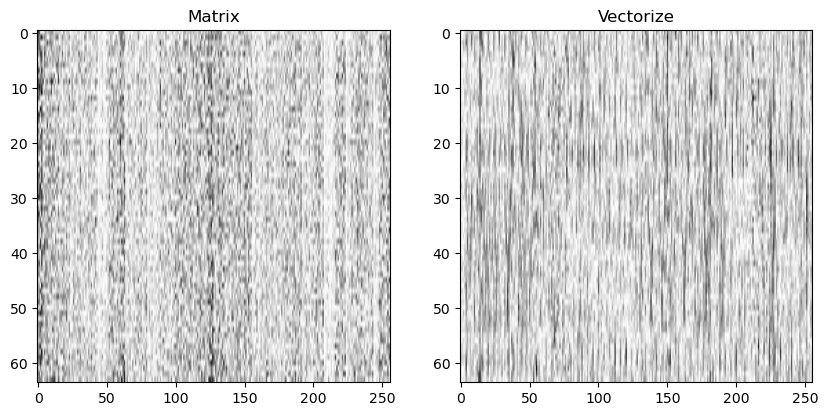

In [10]:
import matplotlib.pyplot as plt

# Get the parameter matrix, scale between 

param_matrix_1 = np.abs(list(model1.parameters())[0].detach().numpy())
param_matrix_2 = np.abs(list(model2.parameters())[0].detach().numpy()).reshape(256, 64)


# create a black and white image gradient
cmap = plt.get_cmap('binary')

fig = plt.figure(figsize= (10, 20))

ax1 = fig.add_subplot(121)
# plot the parameter matrix as an image
ax1.imshow(param_matrix_1.T, cmap=cmap)
ax1.set_aspect(4)
ax1.set_title('Matrix')

ax2 = fig.add_subplot(122)
# plot the parameter matrix as an image
ax2.imshow(param_matrix_2.T, cmap=cmap)
ax2.set_aspect(4)
ax2.set_title('Vectorize')

# show the plot

plt.show()